# Script to aquire and pre-process Planet Lab's (Planetscope) data to an Xarray cube
Planetscope images are high resolution (3m) satellite images from Planet Labs
Planet lab's has a rest api for metadata based search: https://developers.planet.com/docs/apis/data/reference/#tag/Item-Search
More information on search filters etc. can be found here: https://developers.planet.com/docs/apis/data/searches-filtering/
From the results, the images then can be downloaded like indicated here:
https://developers.planet.com/docs/planetschool/downloading-imagery-with-data-api/


In [4]:
## Import libraries
# system
import os
import sys
import time
import calendar
import requests
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor
import threading
import hashlib
from dotenv import load_dotenv

# data manipulation
import json
import yaml
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio # needed for xarray.rio to work
from rasterio.enums import Resampling
import xarray as xr
import rioxarray as rxr
from skimage.exposure import match_histograms
from rioxarray.merge import merge_arrays
from shapely.geometry import box, shape
import utm
from pyproj import CRS

# visualization
from tqdm import tqdm
import matplotlib.pyplot as plt

##### Function to exit on error ######
def exit_with_error(message):
    print(message)
    print("Finishing due to error at", time.strftime("%Y-%m-%d %H:%M:%S"))
    exit(1)

###### setup config variables #######
repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

# import helper functions
sys.path.append(f"{repo_dir}/code/helpers")
from submit_job import submit_job_with_dependency
from landsat_config import get_landsat_config_vars

with open(f"{repo_dir}/code/data_acquisition/config.yml", 'r') as stream:
    config = yaml.safe_load(stream)

# Load .env file
load_dotenv(dotenv_path=f"{repo_dir}/.env")

# planet lab
base_url="https://api.planet.com/data/v1"
planet_api_key=(os.getenv("PLANET_API_KEY"), "")
request_path="/quick-search"
url=f"{base_url}{request_path}"

####### Get the region to process #######
region = config['regions'][2]  # e.g. 'dresden'

# setup folders
big_data_storage_path = config.get("big_data_storage_path", "/work/zt75vipu-master/data")
planet_region_folder = f"{big_data_storage_path}/planet_scope/{region.lower()}"
os.makedirs(planet_region_folder, exist_ok=True)

# get planet config settings
planet_query_config = config.get("planetscope_query", {})
cloud_cover_limit = planet_query_config.get("max_cloud_coverage", 0.1) #max 10% cloud cover
asset_names = planet_query_config.get("asset_names", ["ortho_analytic_4b_sr", "ortho_udm2"])
max_scenes_per_region = planet_query_config.get("max_scenes_per_region", 1)
quality_bands = planet_query_config.get("quality_bands", ["clear"]) # ["clear", "cloud", "shadow", "snow"]
confidence_threshold = planet_query_config.get("confidence_threshold", 50)

In [5]:
####### Get/Define the config parameters ########
config_vars = get_landsat_config_vars(os.path.join(repo_dir, "code/data_acquisition/config.yml"), region)

big_data_storage_path = config_vars["big_data_storage_path"]
landsat_region_folder = config_vars["landsat_region_folder"]

landsat_zarr_name = config_vars["landsat_zarr_name"]
stac_filename = config_vars["stac_filename"]

min_temperature = config_vars["min_temperature"]
max_cloud_cover = config_vars["max_cloud_cover"]
start_year = config_vars["start_year"]
end_year = config_vars["end_year"]
consecutive_days = config_vars["consecutive_days"]
collections = config_vars["collections"]
max_dates_per_year = config_vars["max_dates_per_year"]

planet_zarr_name = f"{planet_region_folder}/planet_config_ge{min_temperature}_cc{max_cloud_cover}_{start_year}_{end_year}.zarr"

print(f"Requesting PlanetScope with Landsat Zarr file: {landsat_zarr_name} for region: {region} at {time.strftime('%Y-%m-%d %H:%M:%S')} to store at {planet_zarr_name}")

Requesting PlanetScope with Landsat Zarr file: /work/zt75vipu-thesis/data/landsat/hamburg/landsat_temperature_ge25_cc10_2019_2024.zarr for region: Hamburg at 2025-11-17 02:32:42 to store at /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_config_ge25_cc10_2019_2024.zarr


In [6]:
######## Planet data processing ########
if os.path.exists(planet_zarr_name):
    print(f"PlanetScope data already exists at {planet_zarr_name}, skipping processing.")
    # exit(0)

############ Define the bbox ############ 
ghsl_df_new = gpd.read_parquet(f"{repo_dir}/data/processed/ghsl_regions.parquet")
bbox_gdf = gpd.GeoDataFrame(geometry=ghsl_df_new[ghsl_df_new["region_name"]==region].bbox, crs="EPSG:4326")
bbox_polygon=json.loads(bbox_gdf.to_json())['features'][0]['geometry']
coordinates=json.loads(bbox_gdf.geometry.to_json())["features"][0]["geometry"]["coordinates"]

PlanetScope data already exists at /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_config_ge25_cc10_2019_2024.zarr, skipping processing.


In [7]:
########## get unique dates from landsat zarr file ##########
#import landsat xarray dataset
landsat_xr_ds=xr.open_zarr(landsat_zarr_name, consolidated=True)

# Get time values from xarray dataset
time_ranges = landsat_xr_ds.time
time_ranges = [pd.to_datetime(timestamp).strftime("%Y-%m-%d") for timestamp in time_ranges.values]

# Remove duplicates and sort
time_ranges = sorted(set(time_ranges))
time_ids=[(i, t) for i, t in enumerate(time_ranges)]


###### get planet scenes for the bbox and time ranges ######
def requestPlanetItemInfo(item_types:list=["PSScene"], date:str=None, cloud_cover_limit:float=None, download:bool=False, further_filters:dict=None):

    # Define filters
    filters=[
            {
            "type":"GeometryFilter",
            "field_name":"geometry",
            "config":{
                "type":"Polygon",
                "coordinates": coordinates,
            }
            },
            # {
            #    "type":"AssetFilter",
            #    "config":[
            #       "ortho_analytic_8b"
            #    ]
        ]
    
    if cloud_cover_limit is not None:
        cloud_cover_filter={
            "type":"RangeFilter",
            "config":{
                "gte":0,
                "lte":cloud_cover_limit #0.6
            },
            "field_name":"cloud_cover"
        }
        filters.append(cloud_cover_filter)
        
    if download:
        download_filter={
            "type":"PermissionFilter",
            "config":[
                "assets:download"
            ]
        }
        filters.append(download_filter)
        
    if further_filters is not None:
        filters.append(further_filters)

    if date is not None:
        year=date.split("-")[0]
        month=int(date.split("-")[1])
        
                
        # define a date range of plus and minus 1 month
        start_month=str(month-1 if month != 1 else 12).zfill(2)
        end_month=str(month+1 if month !=12 else 1).zfill(2)
        end_day=calendar.monthrange(int(year), int(end_month))[1]
        
        local_start_year=year if month != 1 else str(int(year)-1)
        local_end_year=year if month != 12 else str(int(year)+1)

        start=f"{local_start_year}-{start_month}-01"
        end=f"{local_end_year}-{end_month}-{end_day}"
        
        date_range_filter={
            "type":"DateRangeFilter",
            "field_name":"acquired",
            "config":{
                "gte":f"{start}T00:00:00Z",
                "lte":f"{end}T00:00:00Z"
            }
        }
        
        filters.append(date_range_filter)


    payload = {
            "item_types": item_types,
            "filter": {
                "type": "AndFilter",
                "config": filters
            }
        }
    
    print(f"Requesting Planet items for date: {date}", payload)

    # Send POST request
    response=requests.post(url, auth=planet_api_key, json=payload)
    response=response.json()
    if "features" not in response:
        #print(response)
        return None
    else:
        #print(response)
        features_df=pd.DataFrame(response["features"])
        
        return features_df

# planet scope ("PSScene")
item_types=["PSScene"]
meta_filename=f"{planet_region_folder}/planet_ge{min_temperature}_{start_year}_{end_year}_meta.parquet"

if not os.path.exists(meta_filename):

    #thread collect for all time ranges
    with ThreadPoolExecutor(max_workers=8) as executor:
        planet_bydate_list = list(tqdm(executor.map(lambda date: requestPlanetItemInfo(item_types=item_types, date=date, cloud_cover_limit=cloud_cover_limit), time_ranges), total=len(time_ranges)))
        
    #merge all dataframes
    planet_bydate_list=[df for df in planet_bydate_list if df is not None]
    if not planet_bydate_list:
        print("No PlanetScope items found")
        exit_with_error(f"No PlanetScope items found, finishing at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    else:
        planet_bydate_df=pd.concat(planet_bydate_list, ignore_index=True)
        planet_bydate_df.head(2)

    planet_bydate_gdf=gpd.GeoDataFrame(planet_bydate_df, geometry=[shape(geom) for geom in planet_bydate_df["geometry"]], crs="EPSG:4326")

    # Save scene metadata as geoparquet
    planet_bydate_gdf.to_parquet(meta_filename)
else:
    print(f"Metadata file {meta_filename} already exists, loading existing metadata.")
    planet_bydate_gdf=gpd.read_parquet(meta_filename)

print(f"Found {len(planet_bydate_gdf)} PlanetScope scenes for region {region} between {start_year} and {end_year} with max {cloud_cover_limit*100}% cloud cover, metadata saved to {meta_filename}")

/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/numcodecs/__init__.py:129: UserWarning: NumPy version >= 2.0.0 detected. The zfpy library is incompatible with this version of NumPy. Please downgrade to NumPy < 2.0.0 or wait for an update from zfpy.
  from numcodecs.zfpy import ZFPY


Metadata file /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_ge25_2019_2024_meta.parquet already exists, loading existing metadata.
Found 865 PlanetScope scenes for region Hamburg between 2019 and 2024 with max 10.0% cloud cover, metadata saved to /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_ge25_2019_2024_meta.parquet


In [8]:
def mergeNearestRows(df, bbox_gdf, max_distance=0.1, cover_frac_threshold=1):
        '''
        Merges nearest rows of a GeoDataFrame until the merged geometry fully covers a reference bbox_gdf.
        
        Parameters
        ----------
        df : GeoDataFrame
            Input tiles or geometries, sorted by some priority (e.g., temporal closeness)
        bbox_gdf : GeoDataFrame
            Contains the target bounding box (1 row with 1 Polygon/Multipolygon)
        max_distance : float
            Maximum allowed distance for adding new geometries (same units as CRS)
        cover_frac_threshold : float
            Minimum coverage fraction to consider the bbox as sufficiently covered (between 0 and 1)

        Returns
        -------
        merged_gdf : GeoDataFrame
            Merged rows that together cover the full bbox_gdf
        '''
        if df.empty:
            return gpd.GeoDataFrame(columns=df.columns, crs=df.crs)
        
        merged_gdf = gpd.GeoDataFrame()
        bbox_geom = bbox_gdf.union_all()

        while not df.empty:
            row = df.iloc[0]
            df = df.iloc[1:] # exclude the first row
            merged_gdf = pd.concat([merged_gdf, gpd.GeoDataFrame([row], crs=df.crs)], ignore_index=True)

            # Update the merged geometry
            merged_geom = merged_gdf.union_all()

            if merged_geom.covers(bbox_geom):
                # Success: fully covered the bbox
                break
            
            inter_area = merged_geom.intersection(bbox_geom).area
            bbox_area = bbox_geom.area if bbox_geom is not None else 0
            cover_frac = inter_area / bbox_area if bbox_area > 0 else 0
            
            if cover_frac >= cover_frac_threshold:
                break

            # Find the nearest geometries to the current merged geometry
            distances = df.distance(merged_geom)
            if distances.empty:
                break
            
            nearest_idx = distances.idxmin()
            
            # check if others within same distance
            nearby_indices = distances[distances <= distances[nearest_idx]].index.tolist()
            
            # choose the closest one in time
            if len(nearby_indices) > 1:
                nearest_idx = df.loc[nearby_indices, 'time_diff'].idxmin()

            if distances[nearest_idx] < max_distance:
                nearest_row = df.loc[[nearest_idx]]
                df = df.drop(nearest_idx)
                merged_gdf = pd.concat([merged_gdf, nearest_row], ignore_index=True)
            else:
                # If no nearby geometry is available, stop (optional - could also continue and allow gaps)
                break

        inter_area = merged_geom.intersection(bbox_geom).area
        bbox_area = bbox_geom.area if bbox_geom is not None else 0
        cover_frac = inter_area / bbox_area if bbox_area > 0 else 0

        print(f"Coverage fraction of the first date's merged geometries over the bbox: {cover_frac:.2%}")

        # Final check
        if not merged_gdf.union_all().covers(bbox_geom) and cover_frac < cover_frac_threshold:
            raise ValueError("Failed to fully cover the target bbox with available geometries.")

        return merged_gdf


def getPlanetscopeScenesCoverForDate(time_id):
    global landsat_xr_ds, planet_bydate_gdf, bbox_gdf
    
    # Get time values from xarray dataset
    time_stamp = landsat_xr_ds.isel(time=time_id).time.values
    time_stamp = pd.to_datetime(time_stamp).strftime("%Y-%m-%d")
    #time_stamp_flat=time_stamp.replace("-", "")
    time_stamp_flat_month=time_stamp.replace("-", "")[:-2]
    month=int(time_stamp_flat_month[-2:])
    previous_month=str(month-1 if month != 1 else 12).zfill(2)
    previous_month_year=time_stamp_flat_month[:-2] if month != 1 else str(int(time_stamp_flat_month[:-2])-1)
    previous_month_time_stamp_flat=f"{previous_month_year}{previous_month}"
    next_month=str(month+1 if month !=12 else 1).zfill(2)
    next_month_year=time_stamp_flat_month[:-2] if month != 12 else str(int(time_stamp_flat_month[:-2])+1)
    next_month_time_stamp_flat=f"{next_month_year}{next_month}"

    # filter planet_bydate_gdf by id of time_stamp_flat_month, previous_month_time_stamp_flat, next_month_time_stamp_flat
    planet_bydate_gdf_filtered= planet_bydate_gdf[
        planet_bydate_gdf['id'].str.contains(time_stamp_flat_month) | 
        planet_bydate_gdf['id'].str.contains(previous_month_time_stamp_flat) | 
        planet_bydate_gdf['id'].str.contains(next_month_time_stamp_flat)].copy()

    #create date id
    planet_bydate_gdf_filtered['date_id']=planet_bydate_gdf_filtered['id'].str[0:8]
    
    planet_bydate_gdf_filtered_clipped = planet_bydate_gdf_filtered.clip(bbox_gdf)
    
    #get the nearest ids for time_stamp_flat
    planet_bydate_gdf_filtered_clipped.loc[:, 'date_id_dt'] = pd.to_datetime(planet_bydate_gdf_filtered_clipped['date_id'])
    planet_bydate_gdf_filtered_clipped.loc[:, 'time_stamp_dt'] = pd.to_datetime(time_stamp)
    planet_bydate_gdf_filtered_clipped.loc[:, 'time_diff'] = (planet_bydate_gdf_filtered_clipped['date_id_dt'] - planet_bydate_gdf_filtered_clipped['time_stamp_dt']).dt.days
    planet_bydate_gdf_filtered_clipped.loc[:, 'time_diff'] = planet_bydate_gdf_filtered_clipped['time_diff'].abs()

    #sort the dataframe by diff
    planet_bydate_gdf_filtered_clipped.sort_values('time_diff', inplace=True)
    
    planet_scenes_cover_df=mergeNearestRows(planet_bydate_gdf_filtered_clipped, bbox_gdf)
    
    return planet_scenes_cover_df


# reproject gdfs to utm zone
easting, northing, zone_number, zone_letter = utm.from_latlon(bbox_gdf.geometry.centroid.y.values[0], bbox_gdf.geometry.centroid.x.values[0])
is_south = zone_letter < 'N'  # True for southern hemisphere
utm_crs = CRS.from_dict({'proj': 'utm', 'zone': int(zone_number), 'south': is_south})
print(f"UTM CRS: {utm_crs.to_authority()} with zone {zone_number}{zone_letter}")

planet_bydate_gdf = planet_bydate_gdf.to_crs(utm_crs)
bbox_gdf = bbox_gdf.to_crs(utm_crs)

folderpath = f"{planet_region_folder}/planet_tmp"
os.makedirs(folderpath, exist_ok=True)

filenames = []
planet_scope_cover_df_list = []

for time_id, date_value in time_ids:
    filename = f"{folderpath}/planet_scope_cover_{date_value.replace('-','')}.parquet"
    filenames.append(filename)

    if os.path.exists(filename):
        print(f"Loading existing cover file: {filename}")
        try:
            # raise ValueError("Forced error for testing")
            df = gpd.read_parquet(filename)
        except Exception as e:
            print(f"Failed to read {filename} ({e}), recomputing...")
            df = getPlanetscopeScenesCoverForDate(time_id)
            df = df.to_crs("EPSG:4326")
            df.to_parquet(filename)
            print(f"Saved: {filename}")
    else:
        print(f"No existing file for {date_value}, computing cover...")
        df = getPlanetscopeScenesCoverForDate(time_id)
        df = df.to_crs("EPSG:4326")
        df.to_parquet(filename)
        print(f"Saved: {filename}")

    planet_scope_cover_df_list.append((date_value, df))

/tmp/ipykernel_3439529/287128364.py:123: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  easting, northing, zone_number, zone_letter = utm.from_latlon(bbox_gdf.geometry.centroid.y.values[0], bbox_gdf.geometry.centroid.x.values[0])


UTM CRS: ('EPSG', '32632') with zone 32U
Loading existing cover file: /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/planet_scope_cover_20200811.parquet
Loading existing cover file: /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/planet_scope_cover_20210618.parquet
Loading existing cover file: /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/planet_scope_cover_20220824.parquet
Loading existing cover file: /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/planet_scope_cover_20240626.parquet


In [15]:
######### Request download for all scenes #########
### Request download for all files in collection ##
def process_asset(url, asset="ortho_analytic_4b_sr"):
    retries = 0
    max_retries = 20

    while retries < max_retries:
        response = requests.get(url, auth=planet_api_key)

        if response.status_code == 429:
            retry_after = 5
            try:
                if "retry-in" in response.text:
                    retry_after = float(response.text.split("retry-in")[1].strip().split()[0].replace("ms", "")) / 1000.0
            except Exception as e:
                print(f"Failed to parse retry-in from 429 response: {e}")
            
            #print(f"Rate limited (429) - Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
            retries += 1
            continue  # retry the request

        if not response.ok:
            print(f"Failed to fetch asset metadata from {url}. Status code: {response.status_code}, Response text: {response.text}")
            return None
        
        try:
            assets = response.json()
        except requests.JSONDecodeError as e:
            print(f"Failed to decode JSON from {url}. Response text: {response.text}")
            return None

        asset_data = assets.get(asset)
        if not asset_data:
            print(f"No '{asset}' asset found in {url}")
            return None

        if "location" not in asset_data:
            # Activate the asset
            activate_url = asset_data["_links"]["activate"]
            activate_response = requests.get(activate_url, auth=planet_api_key)

            if not activate_response.ok:
                print(f"Failed to activate asset for {url}")
                return None

            # Poll until location appears
            self_url = asset_data["_links"]["_self"]
            max_activation_retries = 60
            retry_count = 0

            while retry_count < max_activation_retries:
                checkstatus_response = requests.get(self_url, auth=planet_api_key)
                checkstatus_assets = checkstatus_response.json()

                if "location" in checkstatus_assets:
                    return checkstatus_assets["location"]

                print(f"Waiting for asset {url} to become available... Retry {retry_count + 1}/{max_activation_retries}")
                time.sleep(30)
                retry_count += 1

            print(f"Asset {url} failed to become available after max retries.")
            return None

        else:
            return asset_data["location"]

    print(f"Asset {url} failed after {max_retries} retries.")
    return None

def download_file(download_url, collection_id, folder_path, id):
    
    if download_url is None:
        print(f"Skipping download for {collection_id}_{id} - no download URL available")
        return False
    
    # Generate a short hash of the URL to make the filename unique
    url_hash = hashlib.md5(download_url.encode()).hexdigest()[:8]
    
    # filename = f"{folder_path}/psscene_{collection_id}_{url_hash}.tif"
    filename = f"{folder_path}/psscene_{collection_id}_{id}.tif"
    
    # print(f"Downloading {filename} into folder {folder_path}...")
    if not os.path.exists(filename):
        print(f"Downloading {filename} into folder {folder_path}...")
        with requests.get(download_url, auth=planet_api_key, stream=True) as response:
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))
            
            with open(filename, 'wb') as f, tqdm(
                desc=f"Downloading {collection_id}_{url_hash} to {filename}",
                total=total_size,
                unit='B',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    bar.update(len(chunk))
            
        # print(f"Downloaded {filename} successfully.")
        return True
    else:
        print(f"File {filename} already exists, skipping download.")
        return False


def requestPlanetItemDownload(collection_gdf_file:str, asset_names:list=["ortho_analytic_4b_sr", "ortho_udm2"]):
    """
    Request Planet item download for each item in the GeoDataFrame.
    
    args:
    collection_gdf_file: str, path to the GeoDataFrame file
    """

    print(f"Requesting Planet item downloads for collection file: {collection_gdf_file} at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    collection=gpd.read_parquet(collection_gdf_file)
    collection_ids=collection.id.to_list()

    scene_date=collection.date_id.iloc[0]
    scene_date=scene_date.replace("-","")
    scene_folderpath=f"{folderpath}/psscene_{scene_date}"
    os.makedirs(scene_folderpath, exist_ok=True)
    
    # rename download_url to download_url_ortho_analytic_4b_sr for backwards compatibility
    collection = collection.rename(columns={"download_url": "download_url_ortho_analytic_4b_sr"})

    # check if download_url column exists
    for asset_name in asset_names:
        if not f'download_url_{asset_name}' in collection.columns or collection[f'download_url_{asset_name}'].isnull().any():

            # get download urls
            download_urls = [None] * len(collection)
            
            # check the rows with missing download urls
            if f'download_url_{asset_name}' in collection.columns:
                missing_rows = collection[collection[f'download_url_{asset_name}'].isnull()]
                #update download urls with existing ones
                for idx, url in collection[f'download_url_{asset_name}'].items():
                    if pd.notna(url):
                        download_urls[idx] = url
            else:
                missing_rows = collection
            missing_indices = missing_rows.index.tolist()
                
            print(f"Requesting download URLs for {len(missing_rows)} missing assets of type {asset_name}...")

            lock = threading.Lock()
            
            assets_urls = pd.DataFrame(missing_rows["_links"].to_list()).assets #  all asset links

            with ThreadPoolExecutor(max_workers=10) as executor:
                # Submit tasks with their corresponding indices
                futures = {
                    executor.submit(process_asset, url, asset_name): (url, idx) 
                    for url, idx in zip(assets_urls, missing_indices)
                }

                for future in as_completed(futures):
                    url, idx = futures[future]
                    try:
                        download_url = future.result()
                    except Exception as e:
                        print(f"Asset worker raised an exception for {url}: {e}")
                        with lock:
                            download_urls[idx] = None
                        continue

                    with lock:
                        download_urls[idx] = download_url
              
            
            print(f"Received {sum(1 for url in download_urls if url is not None)} download URLs for asset type {asset_name}, updating GeoDataFrame...")
            # save to parquet
            collection[f'download_url_{asset_name}'] = pd.Series(download_urls)
            collection.to_parquet(collection_gdf_file)
        else:
            print(f"Download URLs for {collection_gdf_file} already exist, skipping activation request.")
        
        # get download urls from collection
        download_urls = collection[f'download_url_{asset_name}'].to_list()
          
        # prepare indices for download  
        download_urls_dict = {url: i for i, url in enumerate(download_urls)}

        # filter out "downloaded" urls
        download_urls = [url for url in download_urls if url != "downloaded"]

        # check if doubled download urls
        if len(set(download_urls)) < len(download_urls):
            print(f"Warning: Duplicate download URLs found for {collection_gdf_file}.")
            # drop duplicates but keep
            download_urls = list(set(download_urls))  

        print(f"Collected {len(download_urls)} download URLs. Starting downloads for asset type {asset_name}...")

        # download files
        downloaded_files = 0
        for url in download_urls:
            i = download_urls_dict[url]
            if download_file(url, collection_ids[i], scene_folderpath, f"{asset_name}_{i}"):
                downloaded_files += 1

        print(f"Downloaded {downloaded_files} files for {collection_gdf_file}")

    print(f"Completed downloads for {collection_gdf_file}")
    return

In [ ]:
# file_id = 2
# for filename in filenames[file_id:file_id+max_scenes_per_region]:
#     collection = gpd.read_parquet(filename)
#     # collection[f"download_url_ortho_analytic_4b_sr"] = "downloaded"
#     asset_name = "ortho_analytic_4b_sr"
#     # collection.loc[collection.index[21], f"download_url_{asset_name}"] = None
#     # print(not f'download_url_{asset_name}' in collection.columns or collection[f'download_url_{asset_name}'].isnull().any())
#     # display(collection)
#     # collection.to_parquet(filename)

In [22]:
######### request all date downloads #########
# for filename in filenames:
file_id = 0
for filename in filenames[file_id:file_id+max_scenes_per_region]:
    if not os.path.exists(filename):
        print(f"File {filename} does not exist, skipping download.")
        continue
    
    # Request download for each collection
    requestPlanetItemDownload(filename, asset_names=asset_names)
    
    
# submit_job_with_dependency("./process_planetscope.sh", region=region, landsat_zarr_name=landsat_zarr_name, filenames=filenames, region_filenames_json=region_filenames_json)
# exit(0)

Requesting Planet item downloads for collection file: /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/planet_scope_cover_20200811.parquet at 2025-11-17 03:00:33
Download URLs for /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/planet_scope_cover_20200811.parquet already exist, skipping activation request.
Collected 0 download URLs. Starting downloads for asset type ortho_analytic_4b_sr...
Downloaded 0 files for /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/planet_scope_cover_20200811.parquet
Requesting download URLs for 39 missing assets of type ortho_udm2...
Failed to fetch asset metadata from https://api.planet.com/data/v1/item-types/PSScene/items/20200816_100448_1012/assets/. Status code: 401, Response text: {"message": "Please provide valid credentials. See https://docs.planet.com/develop/authentication for help.", "errors": []}
Failed to fetch asset metadata from https://api.planet.com/data/v1/item-types/PSScene/items/20200816_100444_1012/assets/

In [10]:
######### Process all downloaded files #########
quality_bands_dict = {
    'clear': 0,
    'snow': 1,
    'shadow': 2,
    'light_haze': 3,
    'heavy_haze': 4,
    'cloud': 5,
    'confidence': 6,
    'unusable': 7
}

def calculate_quality_statistics(udm, bbox_geom, quality_bands, quality_bands_dict):
    """
    Calculate UDM2 coverage statistics for quality assessment.
    
    Parameters
    ----------
    udm : xarray.DataArray
        UDM2 data with 8 bands
    bbox_geom : shapely.geometry
        Bounding box geometry for area calculation
    quality_bands : list
        List of quality band names to include in the statistics
    quality_bands_dict : dict
        Dictionary mapping quality band names to their corresponding band indices

    Returns
    -------
    dict
        Statistics including percentages for each quality indicator
    """

    total_pixels = udm.isel(band=0).size
    
    stats = {
        'total_pixels': total_pixels,
        'aoi_area_km2': bbox_geom.area / 1e6  # Convert m² to km²
    }
    
    # Band statistics
    for name in quality_bands:
        band_data = udm.isel(band=quality_bands_dict[name])
        coverage_pixels = (band_data == 1).sum().compute().item()
        coverage_percentage = (coverage_pixels / total_pixels) * 100
        stats[f'{name}_percentage'] = coverage_percentage
        stats[f'{name}_pixels'] = coverage_pixels
    
    # Calculate usable percentage (inverse of not clear)
    stats['usable_percentage'] = 100 - stats['clear_percentage']
    
    return stats

def create_quality_mask (udm_file_path: str, bbox_gdf: gpd.GeoDataFrame, quality_bands: list, quality_bands_dict: dict, confidence_threshold: int = 50):
    """
    Create a quality mask from UDM2 file.
    
    Parameters
    ----------
    udm_file_path : str
        Path to the UDM2 file
    bbox_gdf : geopandas.GeoDataFrame
        GeoDataFrame containing the bounding box geometry
    quality_bands : list
        List of quality band names to include in the mask
    quality_bands_dict : dict
        Dictionary mapping quality band names to their corresponding band indices
    confidence_threshold : int
        Threshold for confidence band to consider a pixel as low confidence
        
    Returns
    -------
    xarray.DataArray
        Quality mask where 1 = unusable pixel, 0 = usable pixel
    dict
        Statistics including percentages for each quality indicator
    """
    
    try:
        # Open UDM2 file
        udm = rxr.open_rasterio(udm_file_path, chunks={'x': 1024, 'y': 1024}, masked=False)

        udm = udm.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)

        # Calculate statistics for this tile
        # tile_stats = calculate_quality_statistics(udm, bbox_geom, quality_bands=quality_bands, quality_bands_dict=quality_bands_dict)
        
        # print(f"  Tile stats - Clear: {tile_stats['clear_percentage']:.1f}%, "
        #       f"Cloud: {tile_stats['cloud_percentage']:.1f}%, "
        #       f"Shadow: {tile_stats['shadow_percentage']:.1f}%")
        tile_stats = {}
        
        # UDM2 Band Mapping
        # Band 0 (1): Clear map [0, 1] - 0: not clear, 1: clear
        # Band 1 (2): Snow map [0, 1] - 0: no snow, 1: snow
        # Band 2 (3): Shadow map [0, 1] - 0: no shadow, 1: shadow
        # Band 3 (4): Light haze map [0, 1] - 0: no light haze, 1: light haze
        # Band 4 (5): Heavy haze map [0, 1] - 0: no heavy haze, 1: heavy haze
        # Band 5 (6): Cloud map [0, 1] - 0: no cloud, 1: cloud
        # Band 6 (7): Confidence map [0-100] - percentage confidence
        # Band 7 (8): Unusable pixels - equivalent to UDM asset
        
        # Extract quality masks (True = unusable pixel)
        is_not_clear = udm.isel(band=0) == 0  # Band 1: inverted (0 = not clear)
        is_snow = udm.isel(band=1) == 1       # Band 2: 1 = snow
        is_shadow = udm.isel(band=2) == 1     # Band 3: 1 = shadow
        is_light_haze = udm.isel(band=3) == 1 # Band 4: 1 = light haze
        is_heavy_haze = udm.isel(band=4) == 1 # Band 5: 1 = heavy haze
        is_cloud = udm.isel(band=5) == 1      # Band 6: 1 = cloud
        is_low_confidence = udm.isel(band=6) < confidence_threshold # Band 7 (confidence) - lower confidence = less reliable
        
        # Band 8 (unusable pixels) - non-zero = unusable
        udm_band8 = udm.isel(band=7)
        is_unusable_band8 = udm_band8 != 0
        
        # Combine quality masks based on quality_bands
        quality_mask = xr.zeros_like(udm.isel(band=0), dtype=np.uint8)
        for name in quality_bands:
            if name == 'clear':
                quality_mask = quality_mask | is_not_clear
            elif name == 'snow':
                quality_mask = quality_mask | is_snow
            elif name == 'shadow':
                quality_mask = quality_mask | is_shadow
            elif name == 'light_haze':
                quality_mask = quality_mask | is_light_haze
            elif name == 'heavy_haze':
                quality_mask = quality_mask | is_heavy_haze
            elif name == 'cloud':
                quality_mask = quality_mask | is_cloud
            elif name == 'low_confidence':
                quality_mask = quality_mask | is_low_confidence
            elif name == 'unusable':
                quality_mask = quality_mask | is_unusable_band8               

        # Convert bool to binary (1 = unusable, 0 = usable)
        quality_mask = quality_mask.where(quality_mask == 0, 1)
        quality_mask = quality_mask.rio.write_crs(udm.rio.crs)
        
        return quality_mask, tile_stats
                
    except Exception as e:
        print(f"    Failed to read/convert {udm_file_path}: {e} -- skipping this file")
        return None, None
    
def validate_tiff_file(filepath, sample_fraction=0.1):
    """
    Validate if a TIFF file is readable and not corrupted.
    
    Parameters
    ----------
    filepath : str
        Path to the TIFF file
    sample_fraction : float
        Fraction of the file to sample for validation (0.1 = 10%)
        
    Returns
    -------
    bool
        True if file is valid, False otherwise
    """
    try:
        with rxr.open_rasterio(filepath, masked=False) as test_read:
            # Get dimensions
            y_size = test_read.y.size
            x_size = test_read.x.size
            
            # Sample multiple regions across the file
            sample_points = [
                (0, 0),  # top-left
                (y_size // 2, x_size // 2),  # center
                (max(0, y_size - 100), max(0, x_size - 100)),  # bottom-right
            ]
            
            for y_start, x_start in sample_points:
                y_end = min(y_start + 100, y_size)
                x_end = min(x_start + 100, x_size)
                
                if y_end <= y_start or x_end <= x_start:
                    continue
                    
                _ = test_read.isel(
                    y=slice(y_start, y_end),
                    x=slice(x_start, x_end)
                ).values
                
        return True
    except Exception as e:
        print(f"    Validation failed for {os.path.basename(filepath)}: {e}")
        return False

def check_overlap(da1, da2, threshold):
    from shapely.geometry import box
    box1 = box(*da1.rio.bounds())
    box2 = box(*da2.rio.bounds())
    intersection = box1.intersection(box2)
    if intersection.is_empty:
        return False
    else:
        return intersection.area / box1.area * 100 >= threshold

def create_reference_da_from_bounds(bounds, res, crs="EPSG:4326"):
    """
    Create an empty DataArray template covering bounds = (minx, miny, maxx, maxy)
    with resolution res (units of CRS) and CRS string.
    """
    minx, miny, maxx, maxy = bounds
    # x from left to right, y from top to bottom (descending)
    xs = np.arange(minx + res / 2, maxx, res)
    ys = np.arange(maxy - res / 2, miny, -res)
    arr = np.zeros((ys.size, xs.size), dtype="int16")
    da = xr.DataArray(arr, coords={"y": ys, "x": xs}, dims=("y", "x"))
    da = da.rio.write_crs(crs)
    return da

def readPlanetScopetoXarrayDS(filepair:tuple, bbox_gdf:gpd.GeoDataFrame, quality_bands:list, quality_bands_dict:dict, confidence_threshold:int=50):
    """
    Read PlanetScope tif files to xarray dataset and attach metadata.
    
    args:
    filepath: str, path to the tif file
    bbox_gdf: gpd.GeoDataFrame, bounding box GeoDataFrame for clipping
    quality_bands: list, list of quality band names to include in the quality mask
    quality_bands_dict: dict, dictionary mapping quality band names to their descriptions
    """
    ortho_file = filepair[0]
    udm_file = filepair[1]
    
    
    # Open with chunking for memory efficiency
    xda=rxr.open_rasterio(ortho_file, chunks={'x': 1024, 'y': 1024})
    xda = xda.astype("int16")
    # xda = xda.rio.reproject("EPSG:4326")

    #clip to bbox
    xda = xda.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)

    # rename bands to ['blue', 'green', 'red', 'nir']
    xda=xda.rename({"band": "channel"})
    xda=xda.assign_coords(channel=["blue", "green", "red", "nir"])
    
    # udm/quality processing
    if udm_file:
        udm_xda, udm_stats =create_quality_mask(
            udm_file_path=udm_file,
            bbox_gdf=bbox_gdf,
            quality_bands=quality_bands,
            quality_bands_dict=quality_bands_dict,
            confidence_threshold=confidence_threshold
        )
        
        #filter ortho data with quality mask
        if udm_xda is not None:
            
            if udm_xda.rio.nodata is None and getattr(udm_xda, "_FillValue", None) is not None:
                udm_xda = udm_xda.rio.write_nodata(udm_xda._FillValue, encoded=True)
            
            # match ortho
            udm_xda_matched = udm_xda.rio.reproject_match(
                xda.isel(channel=0),
                resampling=Resampling.nearest
            )
            udm_xda_matched = udm_xda_matched.where(udm_xda_matched != udm_xda_matched._FillValue, np.nan)
            
            xda = xda.where(udm_xda_matched == 0)  # set unusable pixels to nan

        # close udm resources
        if udm_xda is not None:
            udm_xda.close()
        if udm_xda_matched is not None:
            udm_xda_matched.close()

    #remove spatial_ref coords
    # xda=xda.drop_vars(["spatial_ref"])

    #add attributes
    xda=xda.assign_attrs(
        scale_factor=0.0001,
        offset=0.0,
        units= 'reflectance',
        description= 'Analysis-Ready PlanetScope Surface Reflectance'
    )

    #rename variable
    xda=xda.rename("planetscope_sr_4band")

    #process datetime from attributes
    tiff_datetime = xda.attrs["TIFFTAG_DATETIME"]  # "2019:07:27 08:10:45"
    tiff_datetime = tiff_datetime.replace(":", "-", 2)
    xda = xda.expand_dims(time=[np.datetime64(tiff_datetime)])
    
    #remove unneeded attrs
    xda.attrs.pop("TIFFTAG_DATETIME", None)
    
    #add another variable from TIFFTAG_IMAGEDESCRIPTION
    image_description = xda.attrs["TIFFTAG_IMAGEDESCRIPTION"]
    xda.attrs.pop("TIFFTAG_IMAGEDESCRIPTION", None)
    
    # apply scale factor
    # xda = xda * xda.scale_factor + xda.offset
    
    xds=xda.to_dataset()
    xds["meta_planetscope_sr_4band"] = xr.DataArray([image_description], dims=["time"])
    
    return xds

def check_pixel_overlap(tile_da, ref_da, threshold=70):
    # calculate how much of the bbox is covered by the tile
    not_nan_mask = np.isfinite(tile_da.values)
    covered_pixels = np.sum(not_nan_mask)
    total_pixels = ref_da.size
    cover_frac = (covered_pixels / total_pixels) * 100
    print(f"    Tile covers {cover_frac:.2f}% of the reference area.")
    return cover_frac >= threshold
    

def extract_quality_score(xds, ref_da):
    import json
    try:
        attrs = json.loads(xds["meta_planetscope_sr_4band"].values[0])
        ac = attrs["atmospheric_correction"]
        aot = ac["aot_used"]
        zenith = ac["solar_zenith_angle"]
        score = 1 / ((1 + aot) * (1 + zenith))
        
        # check how much of the bbox is covered by the tile
        tile_da = xds["planetscope_sr_4band"].isel(time=0, channel=0)
        if not check_pixel_overlap(tile_da, ref_da, threshold=50):
            print("    Less than 50% overlap with reference area, reducing quality score.")
            score *= 0.5  # reduce score if less than 50% of the region is covered
        else:
            print("    Sufficient overlap with reference area.")
        
        return score
    except:
        return 0  # fallback
    

def histogram_match(source, reference):
    """
    Performs histogram matching between a source and a reference DataArray,
    basing the matching on the overlapping area between them.
    
    Parameters
    ----------
    source : xarray.DataArray
        Source data to be matched (channel, y, x)
    reference : xarray.DataArray
        Reference data for matching (channel, y, x)
    """
    
    # Find overlap region
    source_geom = box(*source.rio.bounds())
    ref_geom = box(*reference.rio.bounds())
    overlap_geom = source_geom.intersection(ref_geom)
    
    if overlap_geom.is_empty:
        print("No overlap - using global histogram matching")
        return histogram_match_global(source, reference)
    
    # Clip to overlap
    source_overlap = source.rio.clip([overlap_geom], source.rio.crs, drop=False)
    ref_overlap = reference.rio.clip([overlap_geom], source.rio.crs, drop=False)
    
    matched_bands = []
    
    for b in range(source.shape[0]):
        src_band = source[b].values.copy()
        src_overlap_band = source_overlap[b].values
        ref_overlap_band = ref_overlap[b].values
        
        # Valid masks
        valid_src = np.isfinite(src_overlap_band) & (src_overlap_band > 0)
        valid_ref = np.isfinite(ref_overlap_band) & (ref_overlap_band > 0)
        
        if not (valid_src.any() and valid_ref.any()):
            matched_bands.append(src_band)
            continue
        
        # percentile-based normalization factors
        src_percentiles = np.percentile(src_overlap_band[valid_src], [2, 98])
        ref_percentiles = np.percentile(ref_overlap_band[valid_ref], [2, 98])
        
        # linear scaling based on percentiles
        scale = (ref_percentiles[1] - ref_percentiles[0]) / (src_percentiles[1] - src_percentiles[0])
        offset = ref_percentiles[0] - (src_percentiles[0] * scale)
        
        # apply
        matched_band = src_band.astype('float32')
        valid_full = np.isfinite(src_band) & (src_band > 0)
        
        # linear scaling with histogram matching
        linear_corrected = src_band[valid_full] * scale + offset
        
        # Apply histogram matching on linearly corrected data
        hist_matched = match_histograms(
            linear_corrected,
            ref_overlap_band[valid_ref]
        )
        
        matched_band[valid_full] = hist_matched
        matched_band[~valid_full] = np.nan
        
        matched_bands.append(matched_band)
    
    # Clean up
    source_overlap.close()
    ref_overlap.close()
    
    return xr.DataArray(
        np.stack(matched_bands),
        dims=source.dims,
        coords=source.coords,
        attrs=source.attrs,
    ).rio.write_crs(source.rio.crs)

def histogram_match_global(source, reference):
    """Fallback global histogram matching."""
    matched_bands = []
    
    for b in range(source.shape[0]):
        src_band = source[b].values.copy()
        ref_band = reference[b].values
        
        valid_src = np.isfinite(src_band) & (src_band > 0)
        valid_ref = np.isfinite(ref_band) & (ref_band > 0)
        
        matched_band = src_band.astype('float32')
        
        if valid_src.any() and valid_ref.any():
            matched_band[valid_src] = match_histograms(
                src_band[valid_src],
                ref_band[valid_ref]
            )
        
        matched_band[~valid_src] = np.nan
        matched_bands.append(matched_band)
    
    return xr.DataArray(
        np.stack(matched_bands),
        dims=source.dims,
        coords=source.coords,
        attrs=source.attrs,
    ).rio.write_crs(source.rio.crs)


    
utm_bounds_gdf = bbox_gdf.to_crs(utm_crs)
bounds = utm_bounds_gdf.total_bounds  # minx, miny, maxx, maxy
res_m = 3.0
ref = create_reference_da_from_bounds(bounds, res_m, crs=utm_crs.to_string())
# ref = ref.rio.reproject("EPSG:4326")
    
for i, filename in enumerate(filenames):
    # if i != 1:
    #     continue  # for testing only process the first date
    
    folderpath = f"{planet_region_folder}/planet_tmp"
    try:
        collection = gpd.read_parquet(filename)
    except Exception as e:
        print(f"  Failed to read collection parquet {filename}: {e} -- skipping")
        continue
    
    scene_date = collection.date_id.iloc[0]
    scene_date = scene_date.replace("-", "")
    collection_folder = f"{folderpath}/psscene_{scene_date}"
    if not os.path.exists(collection_folder):
        print(f"  Collection folder {collection_folder} does not exist -> skipping date {scene_date}")
        continue
    
    planet_date_zarr_name = f"{planet_region_folder}/planet_scope_{scene_date}.zarr"
    
    if os.path.exists(planet_date_zarr_name):
        print(f"PlanetScope data for date {scene_date} already exists at {planet_date_zarr_name}, skipping processing.")
        # exit(0)
        continue
    
    collection_files = [os.path.join(collection_folder, f) for f in os.listdir(collection_folder) if f.lower().endswith(".tif")]
    if not collection_files:
        print(f"  No .tif files found in {collection_folder} -> skipping date {scene_date}")
        continue
    
    ortho_files = [f for f in collection_files if "ortho_analytic_4b_sr" in f]
    if not ortho_files:
        print(f"  No Ortho Analytic files found in {collection_folder} -> skipping date {scene_date}")
        continue
    
    udm_files = [f for f in collection_files if "ortho_udm2" in f]
    if not udm_files:
        print(f"  No UDM2 files found in {collection_folder} -> skipping date {scene_date}")
        continue
    
    file_pairs = []
    print(f"Processing PlanetScope data for date {scene_date} with {len(ortho_files)} tiles...")
    for ortho_file in ortho_files: 
        if not validate_tiff_file(ortho_file):
            print(f"    Corrupted ortho file: {os.path.basename(ortho_file)} -> skipping")
            continue
        
        udm_file = ortho_file.replace("ortho_analytic_4b_sr", "ortho_udm2")
        if os.path.exists(udm_file):
            with rxr.open_rasterio(ortho_file, masked=True) as da_ortho:
                with rxr.open_rasterio(udm_file, masked=True) as da_udm:
                    matching_udm_file = udm_file  
                    if not check_overlap(da_ortho, da_udm, threshold=100):
                        print(f"  UDM2 file {matching_udm_file} does not overlap >100% with ortho file {ortho_file}, searching for another matching UDM2 file...")
                        matching_udm_file = None
        
                        # find udm file that overlaps > 100%
                        for udm_file in udm_files:
                            if not os.path.exists(udm_file):
                                continue
                            try:
                                with rxr.open_rasterio(udm_file, masked=True) as da_udm:
                                    if check_overlap(da_ortho, da_udm, threshold=100):
                                        matching_udm_file = udm_file
                                        break
                            except Exception as e:
                                print(f"  Error checking overlap for {udm_file}: {e}")
                                continue
                    else:
                        if not validate_tiff_file(udm_file):
                            print(f"    Corrupted UDM file: {os.path.basename(udm_file)} -> skipping")
                            matching_udm_file = None
                        else:
                            matching_udm_file = udm_file                          
        if matching_udm_file is None:
            print(f"  No matching UDM2 file found for {ortho_file}")
            file_pairs.append((ortho_file, None))
            continue
        else:
            file_pairs.append((ortho_file, matching_udm_file))

    #read all files
    xds_list = []
    for file_pair in file_pairs:
        try:
            xds = readPlanetScopetoXarrayDS(
                file_pair, 
                bbox_gdf, 
                quality_bands, 
                quality_bands_dict, 
                confidence_threshold
            )
            if xds is not None:
                xds_list.append(xds)
        except Exception as e:
            print(f"    Failed to read/convert {file_pair}: {e} -- skipping these files")

    if not xds_list:
        print(f"  No valid xarray datasets for date {scene_date} -> skipping")
        continue

    # sort by quality
    print(f"Sorting {len(xds_list)} tiles by quality for histogram matching...")
    xds_list.sort(key=lambda ds: extract_quality_score(ds, ref), reverse=True)

    dataarrays = [
        ds["planetscope_sr_4band"].squeeze("time").transpose("channel", "y", "x")
        for ds in xds_list
    ]

    # as float for rio merge later
    dataarrays = [
        da.astype("float32") for da in dataarrays
    ]

    # use the cleanest scene as reference for histogram matching
    reference = dataarrays[0]

    # Apply to all except the reference scene
    print(f"Merging {len(dataarrays)} tiles...")
    if len(dataarrays) > 1:
        for da in dataarrays[1:]:
            try:
                # matched_dataarrays.append(histogram_match(da, reference))
                
                # Validate tile has valid spatial dimensions
                if da.x.size == 0 or da.y.size == 0:
                    print(f"Skipping tile with invalid dimensions: x={da.x.size}, y={da.y.size}")
                    continue
                
                matched = histogram_match(da, reference)
                
                # Validate matched result
                if matched.x.size == 0 or matched.y.size == 0:
                    print(f"Matched tile has invalid dimensions, skipping")
                    continue
                
                reference = merge_arrays(
                    [reference, matched],
                    method="first", # max
                    nodata=np.nan,
                    res=None,
                )
                
                # close matched to free resources
                matched.close()
                
            except Exception as e:
                print(f"Histogram matching failed for one tile: {e} -- using original tile")
        
        # close all dataarrays to free resources
        for da in dataarrays:
            da.close()
    
    # final merged dataarray    
    merged = reference
        
    # back to int16
    # merged = merged.astype("int16")

    # resample to reference dataset
    merged = merged.rio.reproject_match(ref)
    
    # drop nan coords
    merged = merged.dropna("x", how="all").dropna("y", how="all")

    # Add time dimension and rechunk
    scene_date_np=np.datetime64(pd.to_datetime(scene_date))
    merged = merged.expand_dims(time=[scene_date_np])
    
    merged = merged.rio.write_nodata(np.nan)
    merged=merged.chunk({'y': 1024, 'x': 1024, 'time': 1, 'channel': 4})
    
    print("CRS before calling to dataset:", merged.rio.crs)

    # Derive NDVI dataarray from the planetscope data
    #create dataset from merged
    merged = merged.to_dataset(name="planetscope_sr_4band")

    # create ndvi
    merged["ndvi"] = (merged.planetscope_sr_4band.isel(channel=3) - merged.planetscope_sr_4band.isel(channel=2)) / (merged.planetscope_sr_4band.isel(channel=3) + merged.planetscope_sr_4band.isel(channel=2))

    print(f"Shape of merged dataset for date {scene_date}: {merged.dims} with CRS {merged.rio.crs}")

    # this also applies all the transformations (mean() etc. and therefore might take some time)
    # merged.to_zarr(planet_date_zarr_name, mode='w', consolidated=True)
    # encoding = {
    #     "planetscope_sr_4band": {"dtype": "float32", "chunks": (4, 1024, 1024, 1)},
    #     "ndvi": {"dtype": "float32", "chunks": (1, 1024, 1024, 1)},
    #     "channel": {"dtype": "S"}, # string type to avoid UTF 32 zarr warning
    # }
    merged.to_zarr(planet_date_zarr_name, mode="w", zarr_format=3, consolidated=True)
    print(f"Saved merged PlanetScope dataset to {planet_date_zarr_name}")
    
    merged.close() # free resources

    # merged=xr.open_zarr(f"{planet_region_folder}/planet_scope_{scene_date}.zarr")

PlanetScope data for date 20200814 already exists at /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_scope_20200814.zarr, skipping processing.
  Collection folder /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/psscene_20210618 does not exist -> skipping date 20210618
Processing PlanetScope data for date 20220824 with 17 tiles...
  UDM2 file /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/psscene_20220824/psscene_20220824_093455_09_2212_ortho_udm2_2.tif does not overlap >100% with ortho file /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/psscene_20220824/psscene_20220824_093455_09_2212_ortho_analytic_4b_sr_2.tif, searching for another matching UDM2 file...
  UDM2 file /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/psscene_20220824/psscene_20220823_100112_66_2483_ortho_udm2_11.tif does not overlap >100% with ortho file /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/psscene_20220824/psscene_20220823_100112_66_2483_ortho_ana

/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)
/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/dask/array/chunk.py:279: RuntimeWarning: invalid value encountered in cast
  

Sorting 17 tiles by quality for histogram matching...
    Tile covers 22.68% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile covers 20.90% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile covers 45.93% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile covers 29.96% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile covers 39.92% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile covers 9.83% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile covers 28.00% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile covers 9.00% of the reference area.
    Less than 50% overlap with reference area, reducing quality score.
    Tile cov

/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=5, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/zarr/api/asynchronous.py:244: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved merged PlanetScope dataset to /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_scope_20220824.zarr
  Collection folder /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_tmp/psscene_20240626 does not exist -> skipping date 20240626


In [11]:
planet_zarr_filenames = []
for filename in filenames:
    collection=gpd.read_parquet(filename)
    scene_date=collection.date_id.iloc[0]
    scene_date=scene_date.replace("-","")
    planet_date_zarr_name = f"{planet_region_folder}/planet_scope_{scene_date}.zarr"
    planet_zarr_filenames.append(planet_date_zarr_name)

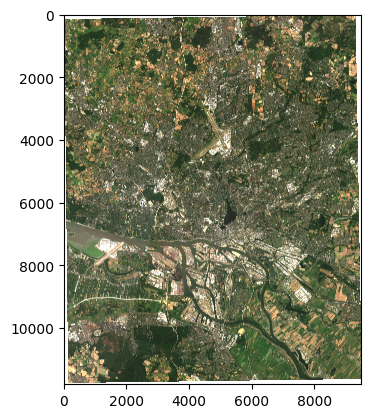

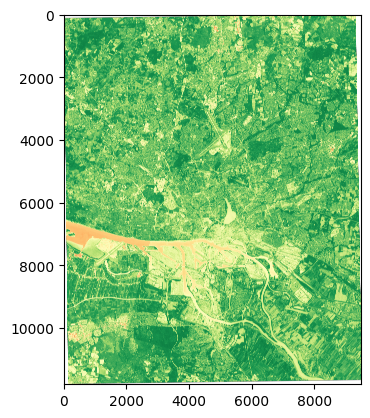

In [23]:
merged = xr.open_zarr(planet_zarr_filenames[2], consolidated=True)

merged_ps = merged.planetscope_sr_4band.isel(time=0)

rgb = np.stack([
    merged_ps.isel(channel=2),
    merged_ps.isel(channel=1),
    merged_ps.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

ndvi = merged.ndvi.isel(time=0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

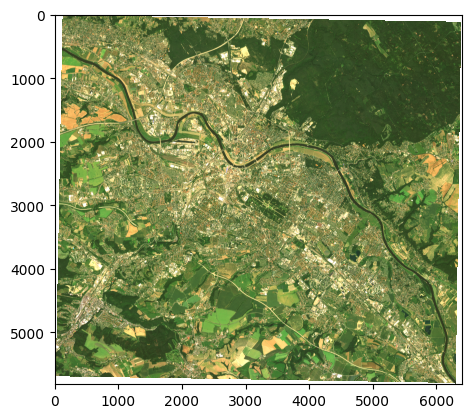

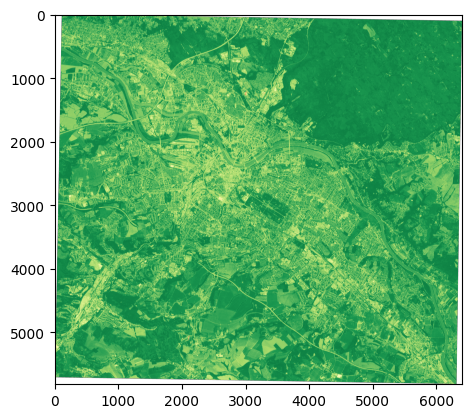

In [14]:
merged = xr.open_zarr(planet_zarr_filenames[0], consolidated=True)

merged_ps = merged.planetscope_sr_4band.isel(time=0)

rgb = np.stack([
    merged_ps.isel(channel=2),
    merged_ps.isel(channel=1),
    merged_ps.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

ndvi = merged.ndvi.isel(time=0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

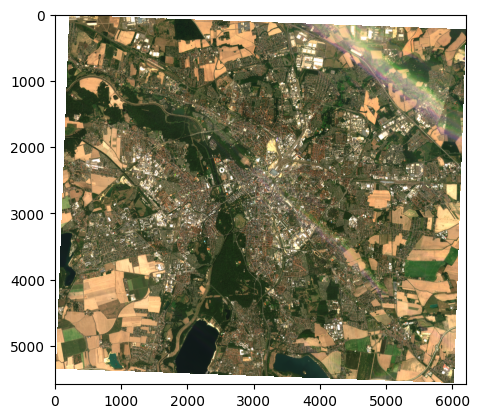

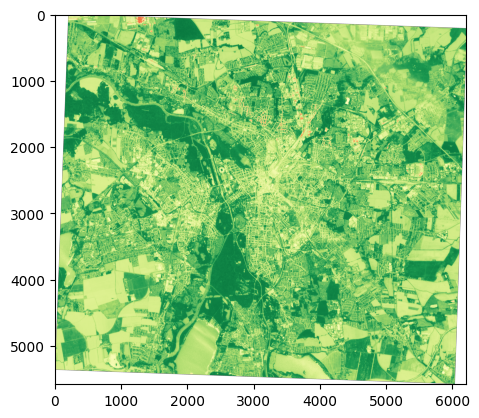

In [ ]:
merged = xr.open_zarr(planet_zarr_filenames[1], consolidated=True)

merged_ps = merged.planetscope_sr_4band.isel(time=0)

rgb = np.stack([
    merged_ps.isel(channel=2),
    merged_ps.isel(channel=1),
    merged_ps.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

ndvi = merged.ndvi.isel(time=0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

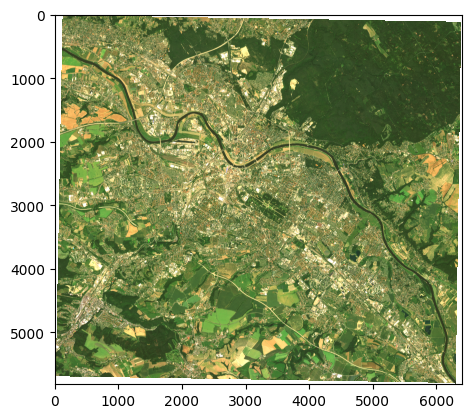

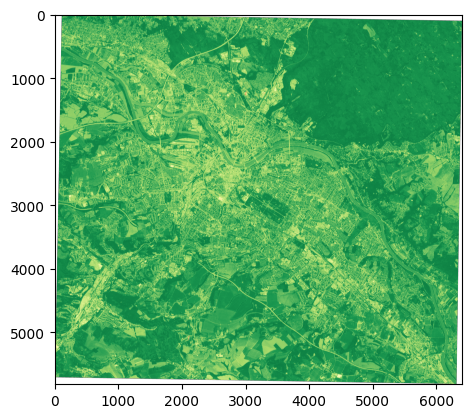

In [ ]:
merged = xr.open_zarr(planet_zarr_filenames[0], consolidated=True)

merged_ps = merged.planetscope_sr_4band.isel(time=0)

rgb = np.stack([
    merged_ps.isel(channel=2),
    merged_ps.isel(channel=1),
    merged_ps.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

ndvi = merged.ndvi.isel(time=0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

<xarray.Dataset> Size: 745MB
Dimensions:               (time: 1, y: 5816, x: 6401, channel: 4)
Coordinates:
  * channel               (channel) <U5 80B 'blue' 'green' 'red' 'nir'
  * y                     (y) float64 47kB 5.664e+06 5.664e+06 ... 5.646e+06
  * x                     (x) float64 51kB 4.032e+05 4.032e+05 ... 4.224e+05
  * time                  (time) datetime64[ns] 8B 2020-08-06
Data variables:
    ndvi                  (time, y, x) float32 149MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    planetscope_sr_4band  (time, channel, y, x) float32 596MB dask.array<chunksize=(1, 4, 1024, 1024), meta=np.ndarray>
    spatial_ref           int64 8B ...

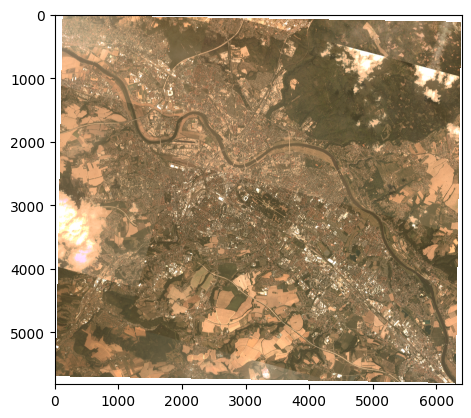

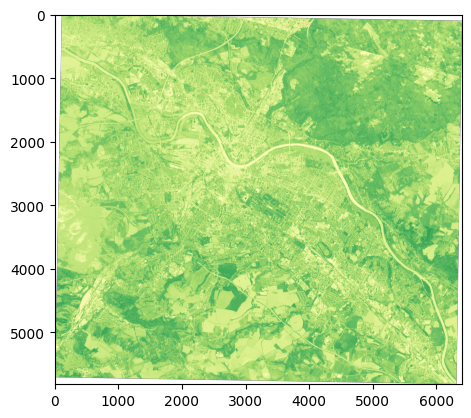

In [ ]:
merged = xr.open_zarr(planet_zarr_filenames[1], consolidated=True)

merged_ps = merged.planetscope_sr_4band.isel(time=0)

display(merged)

rgb = np.stack([
    merged_ps.isel(channel=2),
    merged_ps.isel(channel=1),
    merged_ps.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

# plot ndvi
ndvi = merged.ndvi.isel(time=0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

In [24]:
xr_ds_list = [xr.open_zarr(filename) for filename in planet_zarr_filenames if os.path.exists(filename)]

if not xr_ds_list:
    exit_with_error(f"No valid xarray datasets found in the provided filenames, finishing at {time.strftime('%Y-%m-%d %H:%M:%S')}")

#concat along time dimension
print("Concatenating xarray datasets at", time.strftime("%Y-%m-%d %H:%M:%S"))
xds = xr.concat(xr_ds_list, dim="time")

# rechunk the data to avoid memory issues
print("Rechunking data at", time.strftime("%Y-%m-%d %H:%M:%S"))
xds = xds.chunk({'time': 1, 'y': 1024, 'x': 1024})

# write to zarr
print("Writing to zarr at", time.strftime("%Y-%m-%d %H:%M:%S"))
xds.to_zarr(planet_zarr_name, mode='w', consolidated=True)
print(f"PlanetScope data written to {planet_zarr_name} at {time.strftime('%Y-%m-%d %H:%M:%S')}")

Concatenating xarray datasets at 2025-11-17 03:21:34
Rechunking data at 2025-11-17 03:21:34
Writing to zarr at 2025-11-17 03:21:34


/tmp/ipykernel_3439529/1132417573.py:8: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  xds = xr.concat(xr_ds_list, dim="time")
/home/sc.uni-leipzig.de/zt75vipu/.conda/envs/genaiSpatialplan/lib/python3.11/site-packages/zarr/core/dtype/npy/string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=5, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.co

PlanetScope data written to /work/zt75vipu-thesis/data/planet_scope/hamburg/planet_config_ge25_cc10_2019_2024.zarr at 2025-11-17 03:21:39


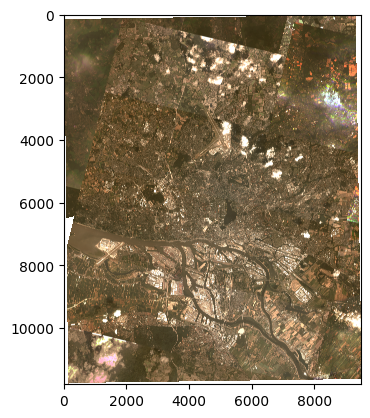

In [ ]:
xds = xr.open_zarr(planet_zarr_name, consolidated=True)
reflectance = xds.planetscope_sr_4band.isel(time=0)

rgb = np.stack([
    reflectance.isel(channel=2),
    reflectance.isel(channel=1),
    reflectance.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

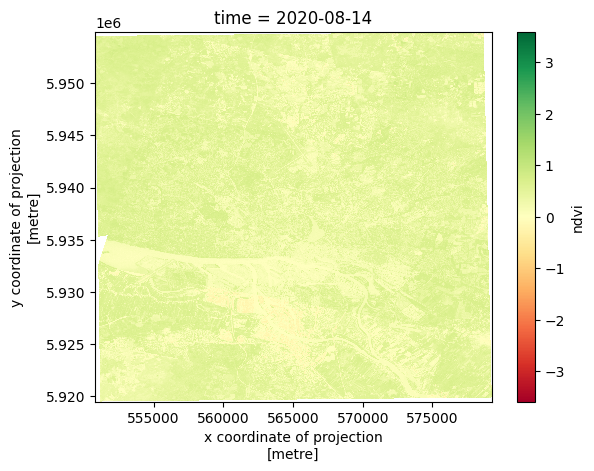

In [ ]:
xds.ndvi.isel(time=0).plot(cmap='RdYlGn')